In [436]:
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api
import os
import csv

In [2]:
pp = pprint.PrettyPrinter(indent=2)
with open('tweet_data/tweets_#gohawks.txt') as json_data:
    for line in json_data:
        d = json.loads(line)
        pp.pprint(d)
        break

{ 'author': { 'author_img': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'description': 'Married to my best friend... You-make me laugh '
                             'and occasionally think... I-will let you in on '
                             'some of the crazy shit that consumes my '
                             'thoughts...',
              'followers': 1752.0,
              'image_url': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'name': 'RJ',
              'nick': 'rejinseattle',
              'type': 'twitter',
              'url': 'http://twitter.com/rejinseattle'},
  'citation_date': 1421518778,
  'citation_url': 'http://twitter.com/REJinseattle/status/556516209261166593',
  'firstpost_date': 1419804875,
  'highlight': 'I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8',
  'metrics': { 'acceleration': 0,
               'citations': { 'data': [ { 'citations': 1,
                 

# 1. Popularity Prediction

#### Initialize variables

In [410]:
hashtags = ['#gopatriots','#nfl','#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
#hashtags = ['#sb49','#gohawks','#patriots','#superbowl'] #using only one tag

#### Reading files into dataframes and storing

In [313]:
df_columns = ['timestamp','tweet_id','author_id','followers','retweets',
              'firstpost',
              'acceleration','impressions','peak', 'ranking_score', 
              'org_followers', 
              'title', 
              'user_mentions', 
              'favorite_count', 'sensitivity', 'retweet_count', 'location']
bypass = False
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        if(not os.path.isfile('temp/'+hashtag+'.csv') or bypass):
            writer=csv.writer(open('temp/'+hashtag+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                #pp.pprint(j)
                #must need columns
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                #useful for later
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                # additional features
                firstpost = j['firstpost_date']
                acceleration = j['metrics']['acceleration']
                impressions = j['metrics']['impressions']
                peak = j['metrics']['peak']
                ranking_score = j['metrics']['ranking_score']
                org_followers = j['original_author']['followers']
                #influence = j['original_author']['influence_level']
                title = j['title']
                user_mentions = j['tweet']['entities']['user_mentions']
                favorite_count = j['tweet']['favorite_count']
                sensitivity = j['tweet']['possibly_sensitive']
                retweet_count = j['tweet']['retweet_count']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp, tweet_id, author_id, followers, retweets,
                           firstpost,
                           acceleration, impressions, peak, ranking_score, 
                           org_followers, 
                           title, 
                           user_mentions, 
                           favorite_count, sensitivity, retweet_count, location])
                line = file_obj.readline()
        else:
            print("File Exists!")

Processing  #gopatriots
File Exists!


In [516]:
df_map = {} # to store dfs for each file
for hashtag in hashtags:
    print('loaded dataframe',hashtag)
    df_map[hashtag] = pd.read_csv('temp/'+hashtag+'.csv')

loaded dataframe #gopatriots
loaded dataframe #nfl
loaded dataframe #sb49
loaded dataframe #gohawks
loaded dataframe #patriots
loaded dataframe #superbowl


In [51]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0,"Boston, Massachusetts"
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0,NaN
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1,NaN
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1,new york city.
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1,"Plantation, FL"


In [ ]:
#df_map['#gopatriots'].to_csv('#gopatriots.csv', encoding='utf-8', index=False)

## 1.1 Statistics

In [19]:
tweets_hrly = {}
retweets_hrly = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_hrly[hashtag] = (retweets_cnt[hashtag]*3600)/sec
    followers_hrly[hashtag] = (followers_cnt[hashtag]*3600)/sec    


In [20]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_hrly)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232, '#nfl': 259024, '#sb49': 826951, '#gohawks': 188136, '#patriots': 489713, '#superbowl': 1346216}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027, '#nfl': 441.3234311373958, '#sb49': 1419.8879074871904, '#gohawks': 325.3715913043311, '#patriots': 834.55550916418849, '#superbowl': 2379.7114714172076}
Retweets Count :  {'#gopatriots': 36727, '#nfl': 398517, '#sb49': 2076597, '#gohawks': 379022, '#patriots': 873068, '#superbowl': 3216922}
Retweets Avg. hourly {'#gopatriots': 63.976147065996216, '#nfl': 678.99071053872058, '#sb49': 3565.5497956035811, '#gohawks': 655.49916698213099, '#patriots': 1487.8586218355645, '#superbowl': 5686.5660384770244}
Followers Count :  {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots': 1620939662.0, '#superbowl': 11915823506.0}
Followers Avg. hourly {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots

## 1.2 Linear Regression

#### K-fold cross validation from our previous project

In [396]:
def perform_10fold(X,y,regressor, print_ = False,shuffle_= True):
    kf = KFold(n_splits=10,shuffle=shuffle_, random_state=0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        if(print_):
            print("Fold : ",i)
            print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
            print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

#### Returns the hour number from timestamp

In [42]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return int(timestamp/3600)

def getDate(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)

In [23]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    grouped.reset_index(inplace=True)
    grouped['hour_of_day','tweet'] = grouped.apply(lambda x: getHourofDay(x['timestamp']*3600), axis=1)
    X_map[hashtag] = grouped.drop(['timestamp','tweet_id_count'],axis=1)
    Y_map[hashtag] = grouped['tweet_id_count']
    #print(grouped)
    

In [24]:
for hashtag in hashtags:
    model = stats_api.OLS(Y_map['#gopatriots'],X_map['#gopatriots']).fit()
    print(model.summary())
    

                            OLS Regression Results                            
Dep. Variable:         tweet_id_count   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.129e+04
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:51:25   Log-Likelihood:                -2216.2
No. Observations:                 447   AIC:                             4440.
Df Residuals:                     443   BIC:                             4457.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
followers_sum           

In [25]:
X_map['#gopatriots'].head()

,followers_sum,followers_max,retweets_sum,"(hour_of_day, tweet)"
0,10955.0,10955.0,4,2
1,1762.0,1762.0,3,3
2,1168.0,600.0,3,5
3,465.0,431.0,3,6
4,2850.0,1425.0,3,7


In [391]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0,"Boston, Massachusetts"
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0,NaN
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1,NaN
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1,new york city.
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1,"Plantation, FL"


<h2>Section 1.3 - Linear model</h2>

In [279]:
feature_names = ['# Tweets', '# Authors', 'Average # Followers', 'Retweets', 'Title length', 'Firstpost',
                 'Acceleration', 'Peak', 'User mentions', 'Impressions', 'Average retweet count', 
                 'Average ranking score', 'Original followers', 'Favorite count', 'Time - Hour']

In [280]:
def plot_func(X, Y, result):
    best_features = result.pvalues.argsort()[:3]
    print("Best feature plots")
    i = 1
    for index in best_features:
        print(feature_names[index])
        plt.title("Best feature "+str(i)+": "+str(feature_names[index]))
        plt.xlabel("Number of tweets for next hour")
        plt.ylabel(feature_names[index])
        plt.scatter(Y, X[:, index])
        plt.show()
        i+=1

In [682]:
def getXY(df,key_val='timestamp',time_type=False):
    if time_type:
        df['timestamp'] = df['timestamp'].apply(lambda x:getDate(x))
        
    if key_val == 'firstpost':
        df['timestamp'] = df['firstpost'].apply(lambda x:getDate(x))
    
    time_series = df.groupby(pd.Grouper(key='timestamp', freq='3600s'))
    time_groups = time_series.groups
    #print(time_groups)
        
    X = np.zeros((len(time_groups), n_features))
    Y = np.zeros((len(time_groups)))
    for i, (interval, group) in enumerate(time_series):
        num_tweets = group.tweet_id.nunique()+1 
        num_authors = group.author_id.nunique()+1
        X[i, 0] = group.tweet_id.nunique()
        X[i, 1] = group.author_id.nunique()
        X[i, 2] = group.followers.sum()/num_authors
        X[i, 3] = group.retweets.sum()
        X[i, 4] = group.title.apply(lambda x:len(x)).max()
        X[i, 5] = group.firstpost.min()
        X[i, 6] = group.acceleration.sum()
        X[i, 7] = group.peak.max()
        X[i, 8] = len(group.user_mentions)
        X[i, 9] = group.impressions.sum()
        X[i,10] = group.retweet_count.sum()/num_tweets
        X[i,11] = group.ranking_score.sum()/num_tweets
        X[i,12] = group.org_followers.sum()
        X[i,13] = group.favorite_count.sum()
        X[i,14] = interval.hour
        
        Y[i] = group.tweet_id.nunique()
    return X, Y

In [631]:
def linear_model(dirname, hashtag, X, Y, print_=False):
    errors = []
    errors2 = []
    #print(hashtag)
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = stats_api.OLS(Y_train, X_train).fit()
        preds = model.predict(X_test)

        errors.append(mean_squared_error(Y_test, preds))
        errors2.append(mean_absolute_error(Y_test, preds))
    print("Linear Model - OLS")
    if print_:
        print(model.summary())
        plot_func(X, Y, model)
    f= open(dirname+hashtag+".csv","w+")
    f.write(model.summary().as_csv())
    f.close()
    print("RMSE: ", np.sqrt(np.mean(errors)))
    print("MAE: ", np.mean(errors2))
    #print(model.summary())
    #return errors

#gopatriots
RMSE:  155.601173453
MAE:  42.4286078462
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     117.1
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          5.61e-156
Time:                        15:11:24   Log-Likelihood:                -3711.6
No. Observations:                 574   AIC:                             7451.
Df Residuals:                     560   BIC:                             7512.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

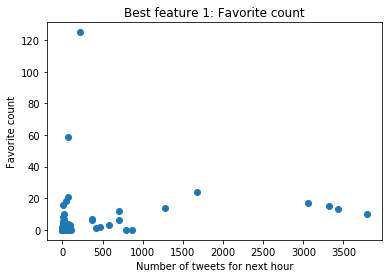

# Authors


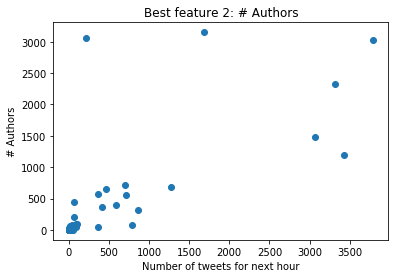

Original followers


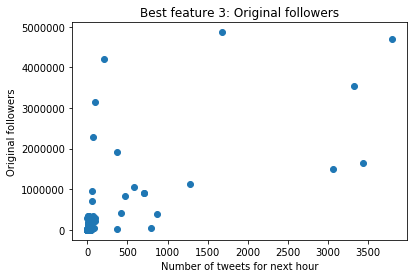

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#nfl
RMSE:  483.24554671
MAE:  178.328983433
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     129.1
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.47e-166
Time:                        15:11:29   Log-Likelihood:                -4453.3
No. Observations:                 586   AIC:                             8935.
Df Residuals:                     572   BIC:                             8996.
Df Model:           

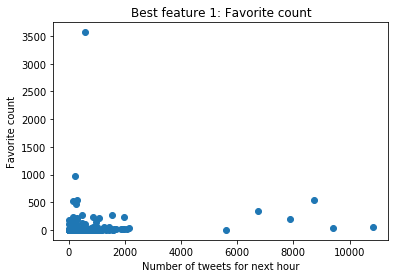

# Tweets


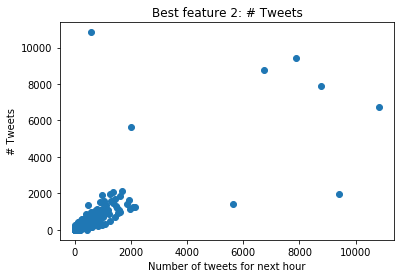

User mentions


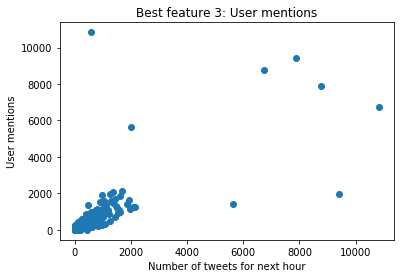

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#sb49
RMSE:  4307.00614908
MAE:  913.573445327
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     187.8
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.74e-202
Time:                        15:11:38   Log-Likelihood:                -5696.0
No. Observations:                 582   AIC:                         1.142e+04
Df Residuals:                     568   BIC:                         1.148e+04
Df Model:         

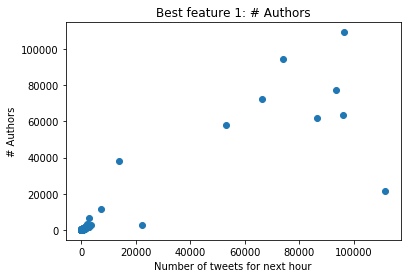

User mentions


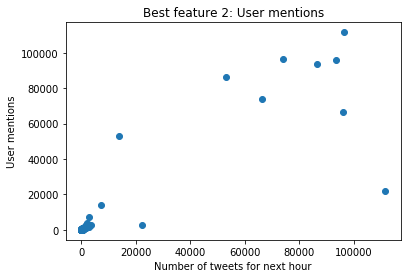

# Tweets


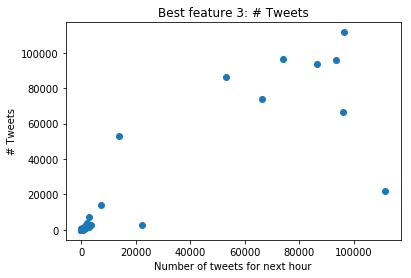

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#gohawks
RMSE:  875.606295582
MAE:  190.096985723
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     59.54
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          2.55e-101
Time:                        15:11:42   Log-Likelihood:                -4736.0
No. Observations:                 578   AIC:                             9500.
Df Residuals:                     564   BIC:                             9561.
Df Model:      

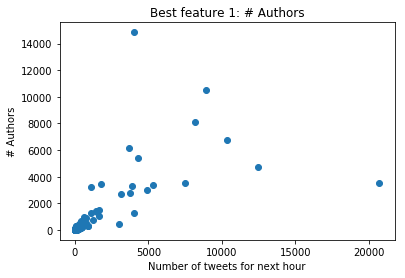

User mentions


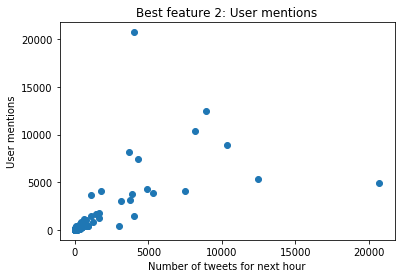

# Tweets


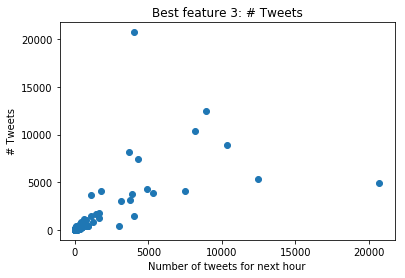

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#patriots
RMSE:  2290.26959227
MAE:  646.613431354
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     115.1
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          5.88e-156
Time:                        15:11:48   Log-Likelihood:                -5365.0
No. Observations:                 586   AIC:                         1.076e+04
Df Residuals:                     572   BIC:                         1.082e+04
Df Model:     

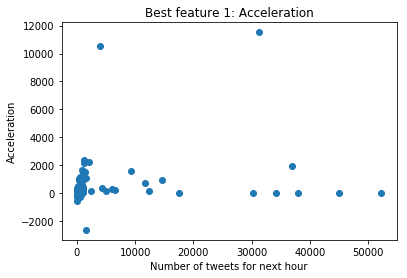

Impressions


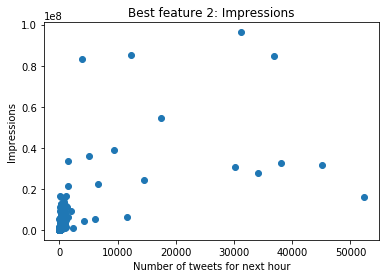

# Authors


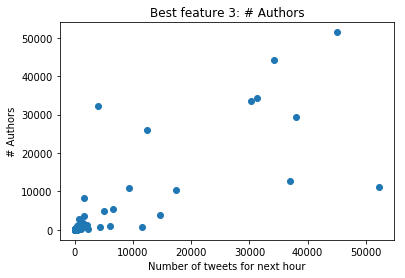

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#superbowl
RMSE:  6835.49788155
MAE:  1678.31962093
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     246.9
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          1.09e-231
Time:                        15:12:00   Log-Likelihood:                -6005.8
No. Observations:                 586   AIC:                         1.204e+04
Df Residuals:                     572   BIC:                         1.210e+04
Df Model:    

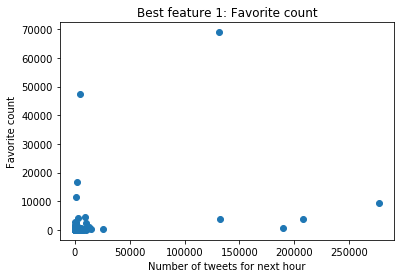

Title length


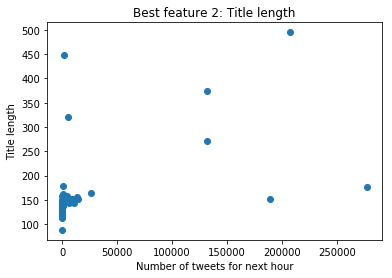

Impressions


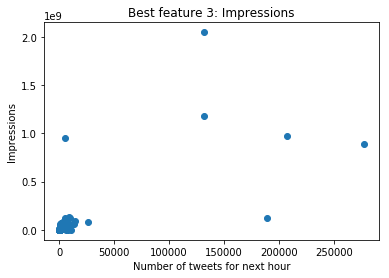

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------


In [676]:
n_features = 15
#hashtags = ['#gopatriots']
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    X, Y = getXY(df,time_type=True)
        
    X = np.nan_to_num(X[:-1])
    Y = Y[1:]
    
    #linear_model('summary1.3/', hashtag, X, Y, True)
    model = stats_api.OLS(Y, pd.DataFrame(X, columns=feature_names)).fit()
    preds = model.predict(X)
    print("RMSE: ", np.sqrt(mean_squared_error(Y, preds)))
    print("MAE: ", mean_absolute_error(Y, preds))
    print(model.summary())
    plot_func(X, Y, model)
    f= open('summary1.3/'+hashtag+".csv","w+")
    f.write(model.summary().as_csv())
    f.close()
    print("-"*100)
    print("*"*100)
    print("-"*100)
    #stats_api.add_constant(X)
    #result = stats_api.OLS(Y, X).fit()
    #print(hashtag)
    #print(result.summary())
    #f= open("summary1.2/"+str(n)+'_'+hashtag+".csv","w+")
    #f.write(model.summary().as_csv())
    #f.close()
    #plot_func(X, Y, result)

<h2>Section 1.3 - Non-linear model</h2>

In [406]:
def plot_func_nonlinear(X, Y, best_features):
    #best_features = result.pvalues.argsort()[:3]
    print("Best feature plots")
    i = 1
    for feature in best_features:
        index = feature_names.index(feature)
        print(feature_names[index])
        plt.title("Best feature "+str(i)+": "+str(feature_names[index]))
        plt.xlabel("Number of tweets for next hour")
        plt.ylabel(feature_names[index])
        plt.scatter(Y, X[:, index])
        plt.show()
        i+=1

In [633]:
def nonlinear_model1(hashtag, X, Y, print_=False):
    errors = []
    errors2= []
    #print(hashtag)
    print("Non-linear model 1 - Random Forest")
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = RandomForestRegressor(n_estimators=25, max_depth=30, max_features=n_features, bootstrap=True, oob_score=True, random_state=42)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)

        errors.append(mean_squared_error(Y_test, preds))
        errors2.append(mean_absolute_error(Y_test, preds))
    best_features = sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names), reverse=True)
    #print(model.summary())
    if print_:
        plot_func_nonlinear(X, Y, [best_features[i][1] for i in range(0,3)])
   
    print("RMSE: ", np.sqrt(np.mean(errors)))
    print("MAE: ", np.mean(errors2))
    #return errors

In [634]:
def nonlinear_model2(hashtag, X, Y):
    errors = []
    errors2 = []
    #print(hashtag)
    print("Non-linear model 2 - Neural Network")
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()  
        scaler.fit(X_train)  
        X_train_ss = scaler.transform(X_train)  
        X_test_ss = scaler.transform(X_test)  
        model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
        model.fit(X_train_ss, Y_train)
        preds = model.predict(X_test_ss)

        errors.append(mean_squared_error(Y_test, preds))
        errors2.append(mean_absolute_error(Y_test, preds))
    
    print("RMSE: ", np.sqrt(np.mean(errors)))
    print("MAE: ", np.mean(errors2))
    #return errors

In [455]:
import warnings
warnings.filterwarnings("ignore")

<h2>Section 1.4 - 54 models</h2>

In [519]:
def calculate_error(X, Y):
    errors = []
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = stats_api.OLS(Y_train, X_train).fit()
        preds = model.predict(X_test)

        errors.append(mean_squared_error(Y_test, preds))

    return np.sqrt(np.mean(errors))

In [637]:
n_features = 15
#hashtags = ['#gopatriots']
df_a = []
df_d = []
df_b = []
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getDate(x))
    
    before = datetime.datetime(2015,2,1,8,0,0)
    after = datetime.datetime(2015,2,1,20,0,0)
     
    df1 = df[df['timestamp'] < before]
    df2 = df[(df['timestamp'] > before) & (df['timestamp'] < after)]
    df3 = df[df['timestamp'] > after]
    
    X1, Y1 = getXY(df1)
    X2, Y2 = getXY(df2)
    X3, Y3 = getXY(df3)
    
    X1 = np.nan_to_num(X1[:-1])
    Y1 = Y1[1:]
    X2 = np.nan_to_num(X2[:-1])
    Y2 = Y2[1:]
    X3 = np.nan_to_num(X3[:-1])
    Y3 = Y3[1:]
    print("Average cross validation errors")
    print("-"*100)
    print("Before superbowl")
    linear_model('summary1.4/linear/before/', hashtag, X1, Y1, False)
    nonlinear_model1(hashtag, X1, Y1)
    nonlinear_model2(hashtag, X1, Y1)
    print("-"*100)
    print("During superbowl")
    linear_model('summary1.4/linear/during/', hashtag, X2, Y2, False)
    nonlinear_model1(hashtag, X2, Y2)
    nonlinear_model2(hashtag, X2, Y2)
    print("-"*100)
    print("After superbowl")
    linear_model('summary1.4/linear/after/', hashtag, X3, Y3, False)
    nonlinear_model1(hashtag, X3, Y3)
    nonlinear_model2(hashtag, X3, Y3)
    
    print("-"*100)
    print("*"*100)
    print("-"*100)
    """
    print("Average cross validation errors")
    print("Before superbowl")
    print(np.sum(calculate_error(X1, Y1))/10.0)
    print("During superbowl")
    print(np.sum(calculate_error(X2, Y2))/10.0)
    print("After superbowl")
    print(np.sum(calculate_error(X3, Y3))/10.0)
    """
    df_a.append(df3)
    df_d.append(df2)
    df_b.append(df1)

#gopatriots
Average cross validation errors
----------------------------------------------------------------------------------------------------
Before superbowl
Linear Model - OLS
RMSE:  52.5310860402
MAE:  12.5929775302
Non-linear model 1 - Random Forest
RMSE:  69.7824642473
MAE:  11.8599486171
Non-linear model 2 - Neural Network
RMSE:  70.3420238344
MAE:  12.0322410148
----------------------------------------------------------------------------------------------------
During superbowl
Linear Model - OLS
RMSE:  823280.112266
MAE:  275909.773526
Non-linear model 1 - Random Forest
RMSE:  872.159937764
MAE:  759.278
Non-linear model 2 - Neural Network
RMSE:  1650.95455722
MAE:  1257.85
----------------------------------------------------------------------------------------------------
After superbowl
Linear Model - OLS
RMSE:  2713.6613878
MAE:  379.077266144
Non-linear model 1 - Random Forest
RMSE:  10.6771744988
MAE:  3.98211825397
Non-linear model 2 - Neural Network
RMSE:  11.43765149

<h2>Section 1.4 - Q2</h2>

In [381]:
df_before = pd.concat(df_b)
df_during = pd.concat(df_d)
df_after = pd.concat(df_a)

In [639]:
X1, Y1 = getXY(df_before)
X2, Y2 = getXY(df_during)
X3, Y3 = getXY(df_after)

X1 = np.nan_to_num(X1[:-1])
Y1 = Y1[1:]
X2 = np.nan_to_num(X2[:-1])
Y2 = Y2[1:]
X3 = np.nan_to_num(X3[:-1])
Y3 = Y3[1:]

print("Average cross validation errors")
print("-"*100)
print("Before superbowl")
linear_model('summary1.4/linear/before/', 'Combined', X1, Y1, False)
nonlinear_model1(hashtag, X1, Y1, False)
nonlinear_model2(hashtag, X1, Y1)
print("-"*100)
print("During superbowl")
linear_model('summary1.4/linear/during/', 'Combined', X2, Y2, False)
nonlinear_model1(hashtag, X2, Y2, False)
nonlinear_model2(hashtag, X2, Y2)
print("-"*100)
print("After superbowl")
linear_model('summary1.4/linear/after/', 'Combined', X3, Y3, False)
nonlinear_model1(hashtag, X3, Y3, False)
nonlinear_model2(hashtag, X3, Y3)

print("-"*100)
print("*"*100)
print("-"*100)

Average cross validation errors
----------------------------------------------------------------------------------------------------
Before superbowl
Linear Model - OLS
RMSE:  2494.95734252
MAE:  785.636454937
Non-linear model 1 - Random Forest
RMSE:  2624.83348255
MAE:  654.281566596
Non-linear model 2 - Neural Network
RMSE:  2319.52856974
MAE:  845.894186047
----------------------------------------------------------------------------------------------------
During superbowl
Linear Model - OLS
RMSE:  36345163.3668
MAE:  15282461.9215
Non-linear model 1 - Random Forest
RMSE:  117980.496128
MAE:  99383.77
Non-linear model 2 - Neural Network
RMSE:  189411.582479
MAE:  157523.4
----------------------------------------------------------------------------------------------------
After superbowl
Linear Model - OLS
RMSE:  364237.623491
MAE:  56288.2962309
Non-linear model 1 - Random Forest
RMSE:  718.999576668
MAE:  429.560153846
Non-linear model 2 - Neural Network
RMSE:  1857.11172062
MAE:  

In [357]:
print(hashtags)

['#gopatriots', '#nfl', '#sb49', '#gohawks', '#patriots', '#superbowl']


<h2>Section 1.5</h2>

In [660]:
#n : number of hours you want to merge
#f : features in each row
#x : X_map value
#y : Y_map value
def getprev_n_merged(n,f,X,y):
    #print(X.head(1))
    #X = X.as_matrix()
    X_new = []
    rnew = []
    for row in X[:n]:
        rnew = rnew + list(row)
    
    X_new.append(rnew)
    for row in X[n:]:
        rnew = rnew[f:]+list(row)
        X_new.append(rnew)
    #print(len(X_new[:-1]),len(list(y[n:])))
    return X_new[:-1],list(y)[n:]

In [686]:
all_data = pd.concat([df_before, df_during, df_after])
print(len(all_data))
X, Y = getXY(all_data, key_val='firstpost')
X = np.nan_to_num(X)
print(len(X))
X_5, Y_5 = getprev_n_merged(5, 15, X, Y) 

3136263
981


In [688]:
model = RandomForestRegressor(n_estimators=25, max_depth=30, max_features=n_features, bootstrap=True, oob_score=True, random_state=42)
model.fit(X_5, Y_5)
#preds = model.predict(X_test)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [485]:
best_features = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_names), reverse=True)

In [619]:
directory = 'test_data/'
for filename in os.listdir(directory):
    print(filename)
    location = directory + filename
    location = 'test_data/sample5_period1.txt'
    with open(location) as json_data:
        for line in json_data:
            d = json.loads(line)
            pp.pprint(d)
            break
    #data = pd.read_csv(location, sep=" ", header=None)
    #data = pd.read_table(location)
    #print(data.head())
    break

sample2_period2.txt
{ 'author': { 'author_img': 'http://pbs.twimg.com/profile_images/378800000630182470/fdb32c75a35a3aa09223338499b21b92_normal.png',
              'description': "T'Lates' #Chicago #News translated inta "
                             '#Rednack\r\n'
                             '#followback',
              'followers': 447.0,
              'image_url': 'http://pbs.twimg.com/profile_images/378800000630182470/fdb32c75a35a3aa09223338499b21b92_normal.png',
              'name': 'Chicago Sum Timez',
              'nick': 'chicagosumtime',
              'type': 'twitter',
              'url': 'http://twitter.com/chicagosumtime'},
  'citation_date': 1422406820,
  'citation_url': '',
  'firstpost_date': 1422406820,
  'highlight': '#Seahawks hero Chris “Hardball” Mat ... #BrandonBostick '
               '#ChisMatthews #ChrisHardballMatthews #CHRISMATTHEWS '
               'http://t.co/DgbBJJBPyb',
  'metrics': { 'acceleration': 0,
               'citations': { 'data': [ { 'citat

In [673]:
directory = 'test_data/'
bypass=False
for filename in os.listdir(directory):
    print(filename)
    location = directory + filename
    filename = filename.strip(".txt")
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",filename)
    with open(location, "r") as file_obj:
        if(not os.path.isfile('temp/1.5/'+filename+'.csv') or bypass):
            writer=csv.writer(open('temp/1.5/'+filename+'.csv','w+'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            #print(line)
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                #pp.pprint(j)
                #must need columns
                timestamp =j['firstpost_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                #useful for later
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                # additional features
                firstpost = j['firstpost_date']
                acceleration = j['metrics']['acceleration']
                impressions = j['metrics']['impressions']
                peak = j['metrics']['peak']
                ranking_score = j['metrics']['ranking_score']
                org_followers = j['original_author']['followers']
                #influence = j['original_author']['influence_level']
                title = j['title']
                user_mentions = j['tweet']['entities']['user_mentions']
                favorite_count = j['tweet']['favorite_count']
                sensitivity = j['tweet']['possibly_sensitive']
                retweet_count = j['tweet']['retweet_count']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp, tweet_id, author_id, followers, retweets,
                           firstpost,
                           acceleration, impressions, peak, ranking_score, 
                           org_followers, 
                           title, 
                           user_mentions, 
                           favorite_count, sensitivity, retweet_count, location])
                print([timestamp, tweet_id, author_id, followers, retweets,
                           firstpost,
                           acceleration, impressions, peak, ranking_score, 
                           org_followers, 
                           title, 
                           user_mentions, 
                           favorite_count, sensitivity, retweet_count, location])
                line = file_obj.readline()

        else:
            print("File Exists!")

sample2_period2.txt
Processing  sample2_period2
File Exists!
sample7_period3.txt
Processing  sample7_period3
File Exists!
sample4_period1.txt
Processing  sample4_period1
File Exists!
sample8_period1.txt
Processing  sample8_period1
File Exists!
sample1_period1.txt
Processing  sample1_period1
File Exists!
sample6_period2.txt
Processing  sample6_period2
File Exists!
sample3_period3.txt
Processing  sample3_period3
File Exists!
sample10_period3.txt
Processing  sample10_period3
File Exists!
sample9_period2.txt
Processing  sample9_period2
File Exists!
sample5_period1.txt
Processing  sample5_period1
0
[1422406820, 560240926732210177, 'http://twitter.com/chicagosumtime', 447.0, 1, 1422406820, 0, 428, 0, 3.9084969, 447.0, '', [], 0, False, 0, 'Chicago, Illinois, USA']
[1422406828, 560240960894799872, 'http://twitter.com/supperclub_la', 12367.0, 1, 1422406828, 0, 12328, 0, 7.49162, 12367.0, '', [], 0, False, 0, '6675 Hollywood Blvd.']
[1422406852, 560241062254350336, 'http://twitter.com/rednekked

[1422414016, 560271109653020673, 'http://twitter.com/mooresauce88', 367.0, 1, 1422414016, 0, 365, 0, 3.7003744, 367.0, '', [{'indices': [0, 8], 'id': 1080342176, 'id_str': '1080342176', 'name': 'Ethan Nauman', 'screen_name': 'ENom020'}], 0, False, 0, 'midwest']
[1422414032, 560271177042894848, 'http://twitter.com/seahawksreddit', 115.0, 1, 1422414032, 0, 101, 0, 4.321475, 115.0, '', [], 0, False, 0, 'Seattle']
[1422414041, 560271214930046976, 'http://twitter.com/larrymcchainsaw', 15.0, 1, 1422414041, 0, 1, 0, 4.1241355, 15.0, '', [], 0, False, 0, 'Monline, Illinois ']
[1422414050, 560271250975903744, 'http://twitter.com/tshirt_hub', 608.0, 1, 1422414050, 0, 608, 0, 4.1500306, 608.0, '', [], 0, False, 0, 'Seattle, WA']
[1422414050, 560271251063980032, 'http://twitter.com/myhiphoptees', 11346.0, 1, 1422414050, 0, 11369, 0, 4.141081, 11346.0, '', [], 0, False, 0, 'Seattle, WA']
[1422414059, 560271288129032192, 'http://twitter.com/bacox87', 173.0, 1, 1422414059, 0, 176, 0, 4.005247, 173.0,

[1422419915, 560295853428989954, 'http://twitter.com/nfl_seahawks1', 783.0, 1, 1422419915, 0, 765, 0, 3.9562075, 783.0, '', [], 0, False, 0, 'Seattle']
[1422419916, 560295857023897600, 'http://twitter.com/scotttwhit', 8.0, 1, 1422419916, 0, 9, 0, 4.2956233, 8.0, '', [], 0, False, 0, 'Buckeye, AZ']
[1422419917, 560295860337008642, 'http://twitter.com/santicadam88', 130.0, 1, 1422419917, 0, 127, 0, 4.074669, 130.0, '', [], 0, False, 0, 'Davenport, Iowa']
[1422419922, 560295880935211009, 'http://twitter.com/packersfantalk', 1535.0, 1, 1422419922, 0, 1308, 0, 4.3214016, 1535.0, '', [], 0, False, 0, 'Green Bay']
[1422419924, 560295888569245696, 'http://twitter.com/ticketcritter', 5698.0, 1, 1422419924, 0, 126, 0, 3.8852887, 5698.0, '', [], 0, False, 0, '']
[1422419929, 560295912358944769, 'http://twitter.com/daniel_weinand', 446.0, 3, 1422419929, 0, 442, 0, 4.795552, 446.0, '', [], 0, False, 0, 'Oklahoma State']
[1422419934, 560295930583605248, 'http://twitter.com/365infocus', 76.0, 1, 1422

In [670]:
df_test = {} # to store dfs for each file
for filename in os.listdir(directory):
    filename = filename.strip(".txt")
    if filename=='sample5_period1':
        continue
    print('loaded dataframe',filename)
    df_test[filename] = pd.read_csv('temp/1.5/'+filename+'.csv')

loaded dataframe sample2_period2
loaded dataframe sample7_period3
loaded dataframe sample4_period1
loaded dataframe sample8_period1
loaded dataframe sample1_period1
loaded dataframe sample6_period2
loaded dataframe sample3_period3
loaded dataframe sample10_period3
loaded dataframe sample9_period2


In [558]:
df_test['sample8_period1']

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1422489605,560588153547800576,http://twitter.com/pbrrockbar,12825.0,2,1422489605,0,12782,0,7.148365,12825.0,NaN,"[{'indices': [70, 79], 'id': 23642374, 'id_str...",0,False,1,"Las Vegas, NV"
1,1422489624,560588232555909120,http://twitter.com/polkadotkreates,1395.0,2,1422489624,0,1250,0,3.762110,1395.0,NaN,[],0,False,2,"Antioch, CA"
2,1422489835,560589115868315649,http://twitter.com/steelersfans6,8.0,1,1422489835,0,7,0,3.943368,8.0,NaN,[],0,False,0,NaN
3,1422489873,560589278359871490,http://twitter.com/indiecoltsfans,0.0,1,1422489873,0,0,0,3.864397,0.0,NaN,[],0,False,0,NaN
4,1422489914,560589449802051584,http://twitter.com/blueoceantweets,1550.0,1,1422489914,0,1516,0,3.873922,1550.0,NaN,[],0,False,0,"Halifax, Nova Scotia"
5,1422490017,560589879973662720,http://twitter.com/jojoandeloise1,430.0,3,1422490017,0,407,0,4.663909,430.0,NaN,"[{'indices': [32, 47], 'id': 66892168, 'id_str...",0,False,0,NaN
6,1422490062,560590068373815296,http://twitter.com/hihidco,3713.0,1,1422490062,0,3230,0,3.672073,3713.0,NaN,[],0,False,0,Sumedang
7,1422490062,560590068369612800,http://twitter.com/hihidco,3713.0,1,1422490062,0,3230,0,3.657698,3713.0,NaN,[],0,False,0,Sumedang
8,1422490247,560590846320713729,http://twitter.com/brownsfans6,1.0,1,1422490247,0,0,0,3.931638,1.0,NaN,[],0,False,0,NaN
9,1422490312,560591118383841280,http://twitter.com/starsports,10707.0,1,1422490312,0,10572,0,7.711754,10707.0,NaN,[],0,False,0,"1 Yonge St., Toronto, Canada"


In [690]:
for filename in os.listdir(directory):
    print(filename)
    filename = filename.strip(".txt")
    if filename=='sample5_period1' :
        continue
    df = df_test[filename].copy()
    #print(df.head())
    df = df.fillna("")
    X_test, Y_test = getXY(df, time_type=True)
    X_test = np.nan_to_num(X_test)
    print(len(X_test[0]))
    if filename=='sample8_period1':
        X_5_test, Y_5_test = getprev_n_merged(4, 15, X_test, Y_test) 
        X_5_new = X_5_test[0]+X_5_test[0][-15:]
        #print(X_5_new)
        #print(len(X_5_new), len(X_5_new[0]))
        preds = model.predict([X_5_new])
        print(preds)
        print("RMSE: ", np.sqrt(mean_squared_error(Y_5_test, preds)))
    else:
        X_5_test, Y_5_test = getprev_n_merged(5, 15, X_test, Y_test) 
        print(len(X_5_test), len(X_5_test[0]))
        preds = model.predict(X_5_test)
        print(preds)
        print("RMSE: ", np.sqrt(mean_squared_error(Y_5_test, preds)))

sample2_period2.txt
15
1 75
[ 80120.]
RMSE:  2803.0
sample7_period3.txt
15
1 75
[ 116.12]
RMSE:  3.88
sample4_period1.txt
15
1 75
[ 276.24]
RMSE:  75.24
sample8_period1.txt
15
[ 104.76]
RMSE:  93.76
sample1_period1.txt
15
1 75
[ 252.52]
RMSE:  74.52
sample6_period2.txt
15
1 75
[ 64835.72]
RMSE:  27528.72
sample3_period3.txt
15
1 75
[ 986.72]
RMSE:  463.72
sample10_period3.txt
15
1 75
[ 90.88]
RMSE:  29.88
sample9_period2.txt
15
1 75
[ 2591.48]
RMSE:  198.52
sample5_period1.txt


In [691]:
best_features = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_names*5), reverse=True)

Best feature plots
Impressions


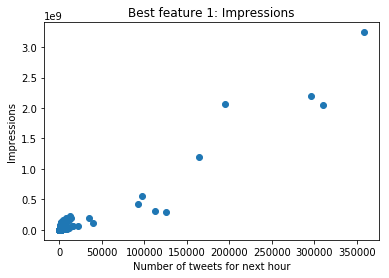

Retweets


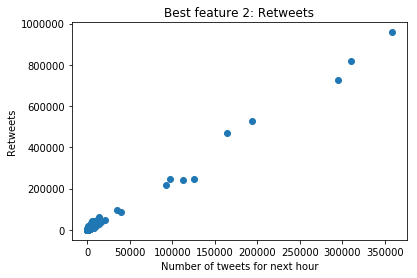

Original followers


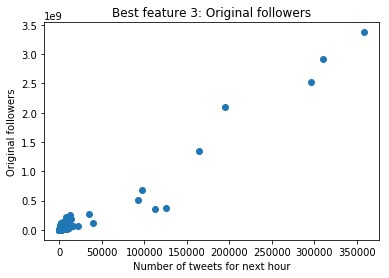

In [692]:
#plot_func_nonlinear(X_5, Y_5, [best_features[i][1] for i in range(0,3)])
print("Best feature plots")
i = 1
for feature in [best_features[i][1] for i in range(0,3)]:
    index = feature_names.index(feature)
    print(feature_names[index])
    plt.title("Best feature "+str(i)+": "+str(feature_names[index]))
    plt.xlabel("Number of tweets for next hour")
    plt.ylabel(feature_names[index])
    plt.scatter(Y, X[:, index])
    plt.show()
    i+=1